/home/jui/.pyenv/versions/3.10.12/envs/myenv/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [12:07:23] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Model Accuracy: 0.8244
Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.95      0.89      5860
           1       0.68      0.38      0.48      1640

    accuracy                           0.82      7500
   macro avg       0.76      0.66      0.69      7500
weighted avg       0.81      0.82      0.80      7500


Final Training Log Loss: 0.3255
Final Test Log Loss: 0.4233


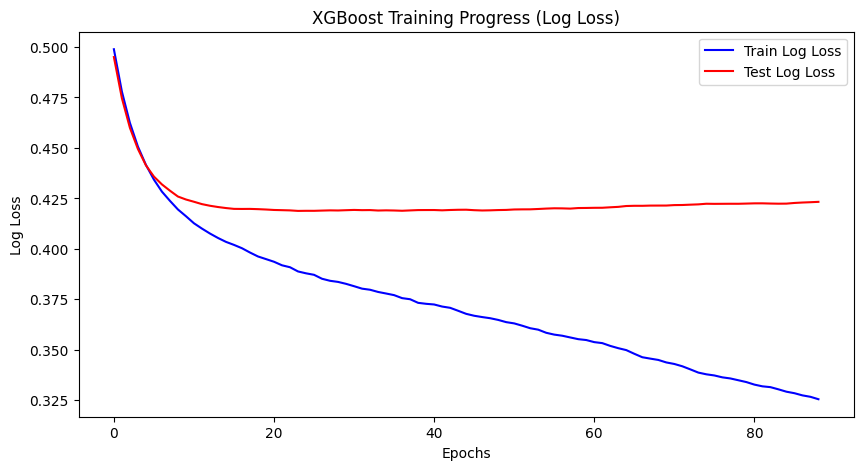

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
import xgboost as xgb
from packaging import version
import sklearn
from sklearn.metrics import accuracy_score, classification_report

df = pd.read_excel("/home/jui/thesis-code/data/credit_card_clients.xls")

def split_label(dataset, target_feature):
    X = dataset.drop([target_feature], axis=1)
    y = dataset[[target_feature]]
    return X, y

# Handle different scikit-learn versions for OneHotEncoder parameters
if version.parse(sklearn.__version__) < version.parse('1.2'):
    ohe_params = {"sparse": False}
else:
    ohe_params = {"sparse_output": False}

def create_classification_pipeline(X):
    pipe_cfg = {
        'num_cols': X.dtypes[X.dtypes == 'int64'].index.values.tolist(),
        'cat_cols': X.dtypes[X.dtypes == 'object'].index.values.tolist(),
    }
    num_pipe = Pipeline([ 
        ('num_imputer', SimpleImputer(strategy='median')),
        ('num_scaler', StandardScaler())
    ])
    cat_pipe = Pipeline([
        ('cat_imputer', SimpleImputer(strategy='constant', fill_value='?')),
        ('cat_encoder', OneHotEncoder(handle_unknown='ignore', **ohe_params))
    ])
    feat_pipe = ColumnTransformer([
        ('num_pipe', num_pipe, pipe_cfg['num_cols']),
        ('cat_pipe', cat_pipe, pipe_cfg['cat_cols'])
    ])

    xgb_model = xgb.XGBClassifier(
        tree_method='hist',  # Fast histogram-based training
        random_state=10,
        n_jobs=-1,  # Use all CPU cores
        learning_rate=0.17,  # Controls step size
        reg_alpha=0.65,  # L1 regularization (sparsity)
        reg_lambda=1.0,  # L2 regularization (weight decay)
        eval_metric='logloss',  # Logarithmic loss for classification
        use_label_encoder=False,  # Avoids unnecessary warnings
        n_estimators=700,
        early_stopping_rounds=65
    )

    pipeline = Pipeline(steps=[('preprocessor', feat_pipe),
                               ('model', xgb_model)])

    return pipeline

target_feature = 'default payment next month'
categorical_features = []

# Split data into features and target
X, y = split_label(df, target_feature)

# Split data into train and test sets (80% training, 20% testing)
X_train_og, X_test_og, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=40)

features = X_train_og.columns.tolist()  # Extract feature names
classes = np.unique(y_train).tolist()  # Extract class labels

# Create the classification pipeline
pipeline = create_classification_pipeline(X_train_og)

# Fit the preprocessor separately to extract feature names
pipeline.named_steps['preprocessor'].fit(X_train_og)

# Extract transformed feature names safely
if hasattr(pipeline.named_steps['preprocessor'], "get_feature_names_out"):
    feature_names = pipeline.named_steps['preprocessor'].get_feature_names_out()
else:
    # Manually construct feature names (for older sklearn versions)
    num_cols = X_train_og.select_dtypes(include=['int64', 'float64']).columns.tolist()
    cat_cols = X_train_og.select_dtypes(include=['object']).columns.tolist()
    feature_names = num_cols + cat_cols  # Not perfect, but works if get_feature_names_out() is missing

# Convert y_train and y_test to NumPy arrays
y_train = y_train.to_numpy()
y_test = y_test.to_numpy()

# Extract XGBClassifier separately and fit with eval_set
xgb_model = pipeline.named_steps['model']
model = xgb_model.fit(pipeline.named_steps['preprocessor'].transform(X_train_og), y_train, 
              eval_set=[(pipeline.named_steps['preprocessor'].transform(X_train_og), y_train),
                        (pipeline.named_steps['preprocessor'].transform(X_test_og), y_test)], verbose=False)

# Make predictions
y_pred = xgb_model.predict(pipeline.named_steps['preprocessor'].transform(X_test_og))

# Compute accuracy and classification report
accuracy = accuracy_score(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

print(f"Model Accuracy: {accuracy:.4f}")
print(f"Classification Report:\n{class_report}\n")

# Extract evaluation results
evals_result = xgb_model.evals_result()

# Get the final log loss for training and testing
train_log_loss = evals_result['validation_0']['logloss'][-1]
test_log_loss = evals_result['validation_1']['logloss'][-1]

# Print the final log loss values for both training and validation
print(f"Final Training Log Loss: {train_log_loss:.4f}")
print(f"Final Test Log Loss: {test_log_loss:.4f}")

# Plot training and validation log loss
plt.figure(figsize=(10, 5))
plt.plot(evals_result['validation_0']['logloss'], label='Train Log Loss', color='blue')
plt.plot(evals_result['validation_1']['logloss'], label='Test Log Loss', color='red')
plt.xlabel("Epochs")
plt.ylabel("Log Loss")
plt.title("XGBoost Training Progress (Log Loss)")
plt.legend()
plt.show()

In [2]:
from art.estimators.classification import XGBoostClassifier
from art.attacks.evasion import ZooAttack
from art.utils import load_mnist

import warnings
warnings.filterwarnings('ignore')

# Convert DataFrame to NumPy array for XGBoost
X_train_np = X_train_og.to_numpy()

# Ensure labels are in the correct shape
y_train_np = np.array(y_train).flatten()

# Assuming train_og_np and y_train_np are NumPy arrays
subset_indices = np.random.choice(X_train_np.shape[0], 7500, replace=False)

# Select random 7500 samples
X_train_subset = X_train_np[subset_indices]
y_train_subset = y_train[subset_indices]

def get_adversarial_examples(X_train_subset, y_train_subset, num_classes=2):
    # Define XGBoost parameters
    num_round = 10
    param = {'objective': 'multi:softprob', 'eval_metric': 'mlogloss', 'num_class': num_classes}

    # Train XGBoost model
    train_data = xgb.DMatrix(X_train_subset, label=y_train_subset)
    model = xgb.train(param, train_data, num_round)

    # Create ART classifier for XGBoost
    art_classifier = XGBoostClassifier(model=model, nb_features=X_train_subset.shape[1], nb_classes=num_classes)

    # Create ART Zeroth Order Optimization attack
    zoo = ZooAttack(classifier=art_classifier, confidence=0.0, targeted=False, learning_rate=1e-1, max_iter=20,
                    binary_search_steps=10, initial_const=1e-3, abort_early=True, use_resize=False, 
                    use_importance=False, nb_parallel=1, batch_size=1, variable_h=0.2)
    
    # Generate adversarial samples
    x_train_adv = zoo.generate(X_train_subset)

    return x_train_adv, model

/home/jui/.pyenv/versions/3.10.12/envs/myenv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
x_train_adv, model = get_adversarial_examples(X_train_subset, y_train_subset, num_classes=2)

ZOO:   0%|          | 0/7500 [00:00<?, ?it/s]

ZOO: 100%|██████████| 7500/7500 [05:20<00:00, 23.39it/s]


Accuracy on Test Set: 77.84%


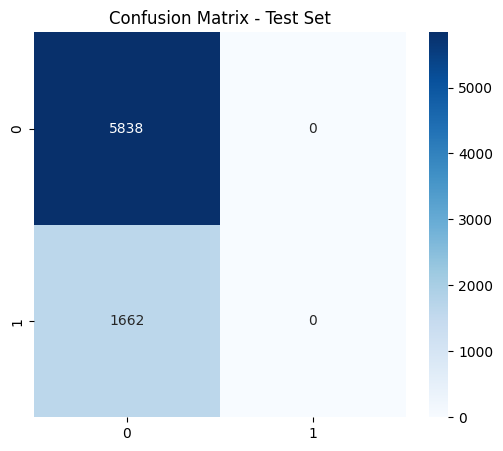

'\n# Transform original and adversarial data using the preprocessor\nX_train_transformed = pipeline.named_steps[\'preprocessor\'].transform(X_train_og)\n# Ensure x_train_adv is a DataFrame\nif isinstance(x_train_adv, np.ndarray):\n    x_train_adv = pd.DataFrame(x_train_adv, columns=X_train_og.columns)\n\nX_train_adv_transformed = pipeline.named_steps[\'preprocessor\'].transform(x_train_adv)\nprint(X_train_adv_transformed.shape)\n\n# Merge original and adversarial datasets\nX_train_combined = np.vstack((X_train_transformed, X_train_adv_transformed))  \nprint(X_train_combined.shape)\n\nprint(y_train.shape)\nprint(y_train_subset.shape)\n\ny_train_combined = np.vstack((y_train, y_train_subset))  \n\n# Shuffle the combined dataset\nX_train, X_test, y_train, y_test = train_test_split(\n    X_train_combined, y_train_combined, test_size=0.25, random_state=40, stratify=y_train_combined\n)\n\n# Train a new XGBoost model on the combined dataset\nxgb_model_combined = xgb.XGBClassifier(\n    tree_m

In [17]:
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split


# Train the model on adversarial data
xgb_model.fit(x_train_adv, y_train_subset, 
                       eval_set=[(X_test_og, y_test)], verbose=False)

# Predictions on the test set (not the original or adversarial training data)
y_pred_test = xgb_model.predict(X_test_og)

# Compute accuracy on the test set
accuracy_test = accuracy_score(y_test, y_pred_test)
print(f"Accuracy on Test Set: {accuracy_test * 100:.2f}%")

# Confusion Matrix for test data
cm_test = confusion_matrix(y_test, y_pred_test)

# Plot Confusion Matrix for the test set
plt.figure(figsize=(6, 5))
sns.heatmap(cm_test, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix - Test Set")
plt.show()


'''
# Transform original and adversarial data using the preprocessor
X_train_transformed = pipeline.named_steps['preprocessor'].transform(X_train_og)
# Ensure x_train_adv is a DataFrame
if isinstance(x_train_adv, np.ndarray):
    x_train_adv = pd.DataFrame(x_train_adv, columns=X_train_og.columns)

X_train_adv_transformed = pipeline.named_steps['preprocessor'].transform(x_train_adv)
print(X_train_adv_transformed.shape)

# Merge original and adversarial datasets
X_train_combined = np.vstack((X_train_transformed, X_train_adv_transformed))  
print(X_train_combined.shape)

print(y_train.shape)
print(y_train_subset.shape)

y_train_combined = np.vstack((y_train, y_train_subset))  

# Shuffle the combined dataset
X_train, X_test, y_train, y_test = train_test_split(
    X_train_combined, y_train_combined, test_size=0.25, random_state=40, stratify=y_train_combined
)

# Train a new XGBoost model on the combined dataset
xgb_model_combined = xgb.XGBClassifier(
    tree_method='hist',  
    random_state=10,
    n_jobs=-1,  
    learning_rate=0.17,  
    reg_alpha=0.65,  
    reg_lambda=1.0,  
    eval_metric='logloss',  
    use_label_encoder=False,  
    n_estimators=700,
    early_stopping_rounds=65
)

xgb_model_combined.fit(
    X_train, y_train,
    eval_set=[(X_train, y_train), (X_test, y_test)],
    verbose=False
)

# Predictions on the test set
y_pred = xgb_model_combined.predict(X_test)

# Compute accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy on Merged Dataset: {accuracy * 100:.2f}%")

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)

# Plot Confusion Matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix - Merged Dataset")
plt.show()

# Extract evaluation results
evals_result_combined = xgb_model_combined.evals_result()

# Plot training and validation log loss
plt.figure(figsize=(10, 5))
plt.plot(evals_result_combined['validation_0']['logloss'], label='Train Log Loss', color='blue')
plt.plot(evals_result_combined['validation_1']['logloss'], label='Test Log Loss', color='red')
plt.xlabel("Epochs")
plt.ylabel("Log Loss")
plt.title("XGBoost Training Progress (Merged Dataset)")
plt.legend()
plt.show()
'''

In [17]:
import numpy as np
import xgboost as xgb
from art.attacks.evasion import LowProFool
from sklearn.metrics import accuracy_score

def execute_lowprofool_xgboost(model, X_train, y_train, X_test, y_test):
    
    # Initialize LowProFool
    lpf = LowProFool(
        classifier=model,
        n_steps=15,
        eta=15,
        lambd=1.75,
        eta_decay=0.985,
        verbose=True
    )
    
    # Fit feature importances (optional)
    lpf.fit_importances(X_train, y_train)
    
    # Generate adversarial examples
    X_adv, y_adv = lpf.generate(X_test, y_test)
    
    # Evaluate model on poisoned data
    y_pred_poisoned = model.predict(X_adv)
    acc_poisoned = accuracy_score(y_adv, y_pred_poisoned)
    print(f"Accuracy After LowProFool Attack: {acc_poisoned:.4f}")
    
    return acc_poisoned


In [18]:
acc_after = execute_lowprofool_xgboost(xgb_model, X_train_og, y_train, X_test_og, y_test)

EstimatorError: LowProFool requires an estimator derived from <class 'art.estimators.estimator.BaseEstimator'> and <class 'art.estimators.estimator.LossGradientsMixin'> and <class 'art.estimators.classification.classifier.ClassifierMixin'>, the provided classifier is an instance of <class 'xgboost.sklearn.XGBClassifier'> and is derived from (<class 'xgboost.sklearn.XGBModel'>, <class 'sklearn.base.ClassifierMixin'>).